In [1]:
#import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
from sklearn.model_selection import train_test_split


In [2]:
### Pickled data
import pickle
cleaned_data = pd.read_pickle(r"C:\Users\maorb\Classes\Classical_ML\YDATA-kaggle-assignment\data\processed\cleaned_data_Maor.pkl")
X_train = pd.read_pickle(r"C:\Users\maorb\Classes\Classical_ML\YDATA-kaggle-assignment\data\processed\X_train.pkl")
X_test = pd.read_pickle(r"C:\Users\maorb\Classes\Classical_ML\YDATA-kaggle-assignment\data\processed\X_test.pkl")
y_train = pd.read_pickle(r"C:\Users\maorb\Classes\Classical_ML\YDATA-kaggle-assignment\data\processed\y_train.pkl")
y_test = pd.read_pickle(r"C:\Users\maorb\Classes\Classical_ML\YDATA-kaggle-assignment\data\processed\y_test.pkl")
predictions = pd.read_csv(r'C:\Users\maorb\Classes\Classical_ML\YDATA-kaggle-assignment\predictions\predictions.csv')
X_train_fold_0 = pd.read_pickle(r"C:\Users\maorb\Classes\Classical_ML\YDATA-kaggle-assignment\data\processed\X_train_fold_0.pkl")
y_val_fold_3 = pd.read_pickle(r"C:\Users\maorb\Classes\Classical_ML\YDATA-kaggle-assignment\data\processed\y_val_fold_3.pkl")
X_test_1st = pd.read_pickle(r"C:\Users\maorb\Classes\Classical_ML\YDATA-kaggle-assignment\data\processed\X_test_DoNotTouch.pkl")
predictions_1st = pd.read_csv(r'C:\Users\maorb\Classes\Classical_ML\YDATA-kaggle-assignment\data\Predictions\predictionscatboost.csv',
                                header=None)


In [5]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 293420 entries, 252105 to 123279
Data columns (total 15 columns):
 #   Column                   Non-Null Count   Dtype   
---  ------                   --------------   -----   
 0   product                  293420 non-null  category
 1   campaign_id              293420 non-null  category
 2   webpage_id               293420 non-null  category
 3   user_group_id            293420 non-null  category
 4   gender                   293420 non-null  category
 5   age_level                293420 non-null  float64 
 6   user_depth               293420 non-null  float64 
 7   city_development_index   293420 non-null  float64 
 8   var_1                    293420 non-null  float64 
 9   product_category         293420 non-null  category
 10  Day                      293420 non-null  float64 
 11  Hour                     293420 non-null  float64 
 12  Minute                   293420 non-null  float64 
 13  weekday                  293420 non-null  fl

In [3]:
import pymc as pm

In [4]:
def determine_categorical_features(df: pd.DataFrame, cat_features: list = None): ## For catboost
        """
        Identify and process categorical features, ensuring compatibility with CatBoost.
        """
        df = df.copy()
        cat_cols = ["product_category", "product", "gender", "campaign_id", "webpage_id", "user_group_id"]
        for col in cat_cols:
            if col in df.columns:
                if col in ["campaign_id", "webpage_id", "user_group_id", "product_category"]:
                    df[col] = df[col].astype("Int64").astype("category")
                else:
                    df[col] = df[col].astype("category")
        if cat_features:
            cat_features = [col for col in cat_features if col in df.columns]
        else:
            cat_features = df.select_dtypes(include=['object', 'category']).columns.tolist()

        for col in cat_features:
            if col in df.columns:

                # Add "missing" only if it's not already a category
                if "missing" not in df[col].cat.categories:
                    df[col] = df[col].cat.add_categories("missing")

                # Fill missing values with "missing"
                df[col] = df[col].fillna("missing")

        return df, cat_features

In [5]:
full_train,_ = determine_categorical_features(cleaned_data)

In [6]:
import pandas as pd
# Suppose df is your entire dataset with user_id, campaign_id, product, is_click
group_cols = ["user_id", "campaign_id", "product", "product_category", "user_group_id","user_depth", "webpage_id"]

grouped = full_train.groupby(group_cols, observed= True)["is_click"].agg(
    impressions="count", 
    clicks="sum"
).reset_index()

# Now each row in `grouped` has (user_id, campaign_id, product, impressions, clicks)


In [7]:
# Suppose grouped has columns: user_id, campaign_id, product, impressions, clicks
# Convert user_id, campaign_id, product to integer indexes for PyMC
grouped["user_idx"] = grouped["user_id"].astype("category").cat.codes
grouped["camp_idx"] = grouped["campaign_id"].astype("category").cat.codes
grouped["prod_idx"] = grouped["product"].astype("category").cat.codes

num_users = grouped["user_idx"].nunique()
num_camps = grouped["camp_idx"].nunique()
num_prods = grouped["prod_idx"].nunique()

In [8]:
import pymc as pm

with pm.Model() as model:
    # Global intercept ~ Normal(-3, 2) => typical CTR ~ 5% a priori
    global_alpha = pm.Normal("global_alpha", mu=-3, sigma=2)

    # Scale params for each level
    sigma_user = pm.HalfCauchy("sigma_user", 5)
    sigma_campaign = pm.HalfCauchy("sigma_campaign", 5)
    sigma_product = pm.HalfCauchy("sigma_product", 5)

    # Offsets (random effects) for each user, campaign, product
    user_offset = pm.Normal("user_offset", mu=0, sigma=1, shape=num_users)
    camp_offset = pm.Normal("camp_offset", mu=0, sigma=1, shape=num_camps)
    prod_offset = pm.Normal("prod_offset", mu=0, sigma=1, shape=num_prods)

    # Logit for each group
    # logit_ctr_g = global_alpha + sigma_user*user_offset[u] + ...
    logit_ctr = (
        global_alpha
        + sigma_user * user_offset[grouped["user_idx"]]
        + sigma_campaign * camp_offset[grouped["camp_idx"]]
        + sigma_product * prod_offset[grouped["prod_idx"]]
    )

    # Convert logit to probability
    p = pm.math.sigmoid(logit_ctr)

    # Observed clicks out of impressions
    clicks_obs = pm.Binomial(
        "clicks_obs",
        n=grouped["impressions"].values,
        p=p,
        observed=grouped["clicks"].values
    )

    # Sample
    trace = pm.sample(
    draws=500, tune=500, chains=1,
    cores=1,  # Avoids multiprocessing overhead
    nuts_sampler="numpyro",
    progressbar=True, target_accept=0.9)



sample: 100%|██████████| 1000/1000 [2:42:15<00:00,  9.74s/it, 127 steps of size 4.02e-02. acc. prob=0.94]  
Only one chain was sampled, this makes it impossible to run some convergence checks


In [13]:
#save trace
import pickle
with open(r"C:\Users\maorb\Classes\Classical_ML\YDATA-kaggle-assignment\models\pymc3_model.pkl", "wb") as buff:
    pickle.dump(trace, buff)

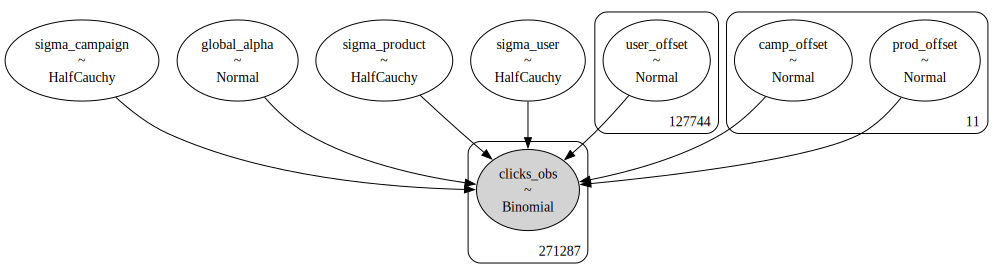

In [15]:
pm.model_to_graphviz(model)

In [16]:
import arviz as az

In [23]:
trace

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

<Axes: >

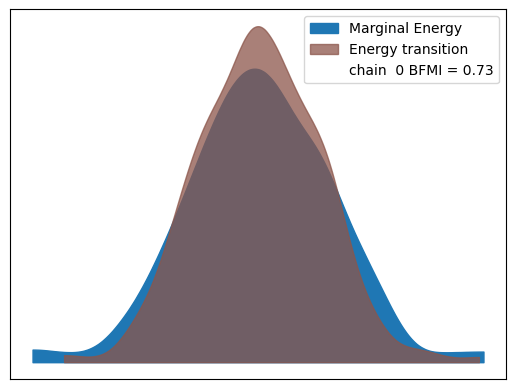

In [18]:
az.plot_energy(trace)

In [39]:
X_train.shape

(293420, 15)

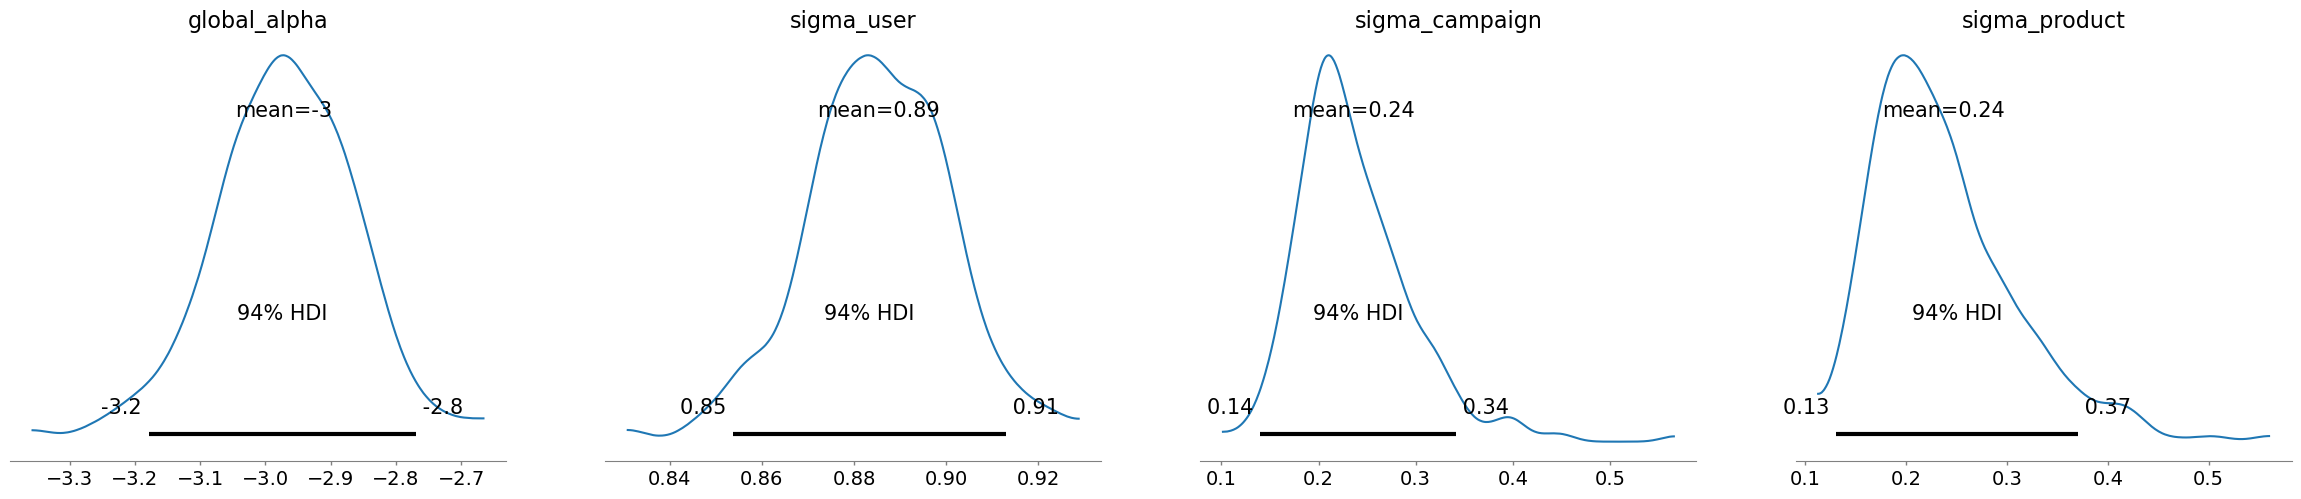

In [ ]:
az.plot_posterior(trace, var_names=["global_alpha", "sigma_user", "sigma_campaign", "sigma_product"]);

KeyboardInterrupt: 

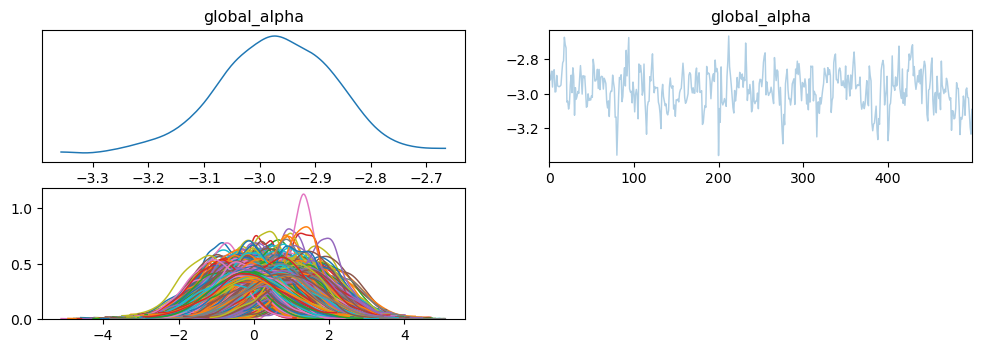

In [22]:
import matplotlib.pyplot as plt
az.plot_trace(trace)
plt.subplots_adjust(wspace=0.5, hspace=0.5)

In [ ]:
with model:
    ppc = pm.sample_posterior_predictive(trace, samples=500)

In [73]:
import numpy as np

posterior = trace.posterior  # xarray with samples
# Suppose we want the mean for each user_id
user_offset_mean = np.mean(posterior["user_offset"].values, axis=(0,1))  # (chain, draw, user_dim)
campaign_offset_mean = np.mean(posterior["camp_offset"].values, axis=(0,1))
product_offset_mean = np.mean(posterior["prod_offset"].values, axis=(0,1))
sigma_user_mean = np.mean(posterior["sigma_user"].values, axis=(0,1))
sigma_campaign_mean = np.mean(posterior["sigma_campaign"].values, axis=(0,1))
sigma_product_mean = np.mean(posterior["sigma_product"].values, axis=(0,1))

# Global alpha
global_alpha_mean = np.mean(posterior["global_alpha"].values, axis=(0,1))

# Then for each (user, campaign, product) we can compute a "hierarchical CTR" in logit space:
def hierarchical_logit(user_id, campaign_id, product_id):
    return global_alpha_mean  \
            + sigma_user_mean * user_offset_mean[user_id] \
            + sigma_campaign_mean * campaign_offset_mean[campaign_id] \
            + sigma_product_mean * product_offset_mean[product_id]

# Convert to probability
def hierarchical_ctr(u, c, p):
    logit_val = hierarchical_logit(u, c, p)
    return 1.0 / (1.0 + np.exp(-logit_val))


In [92]:
product_offset_mean.shape

(11,)

In [86]:
user_offset_mean.sum()

16.523507457722697

In [79]:
#define idx
full_train["user_idx"] = full_train["user_id"].astype("category").cat.codes
full_train["camp_idx"] = full_train["campaign_id"].astype("category").cat.codes
full_train["prod_idx"] = full_train["product"].astype("category").cat.codes

full_train["user_idx"] = full_train["user_idx"].astype(int)
full_train["camp_idx"] = full_train["camp_idx"].astype(int)
full_train["prod_idx"] = full_train["prod_idx"].astype(int)


full_train["hier_ctr"] = full_train.apply(
    lambda row: hierarchical_ctr("user_idx", "camp_idx", "prod_idx"),axis=1)


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [36]:
user_offset_mean.shape

(127744,)

In [83]:
full_train["user_idx"].shape

(365798,)

In [78]:
full_train["hier_ctr"] = full_train.apply(
    lambda row: hierarchical_ctr(row["user_idx"], row["camp_idx"], row["prod_idx"]), axis=1
)


IndexError: index 131548 is out of bounds for axis 0 with size 127744

In [53]:
print(f"Max user_idx: {full_train['user_idx'].max()}, Expected: {len(user_offset_mean)}")
print(f"Max camp_idx: {full_train['camp_idx'].max()}, Expected: {len(campaign_offset_mean)}")
print(f"Max prod_idx: {full_train['prod_idx'].max()}, Expected: {len(product_offset_mean)}")


Max user_idx: 133537, Expected: 127744
Max camp_idx: 10, Expected: 11
Max prod_idx: 10, Expected: 11
